In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(seed=42)

In [46]:
def compare_one_group(y, group=None, n_samples=1000):
    
    # Check to see if group variable was passed. If so, then this means the goal is to compare
    # difference scores on a within subjects variable (e.g., time). Otherwise, we are comparing 
    # location parameter to zero.
    if group is None:
        pass
    else:
        group = group.astype('category')
        level = group.cat.categories
        assert len(level) == 2, f"Expected two groups but got {len(level)}"
        y = y[group==level[1]].to_numpy() - y[group==level[0]].to_numpy()
    
    with pm.Model() as model:
        # Set priors
        mu = pm.Normal('mu', mu=y.mean(), sd=y.std()*100)
        sigma = pm.Uniform('sigma', y.std()/1000, y.std()*1000)
        nu_minus1 = pm.Exponential('nu_minus_one', 1/29)
        nu = pm.Deterministic('nu', nu_minus1 + 1)

        like = pm.StudentT('like', nu, mu, sd=sigma, observed=y)

        # Sample from posterior
        idata = pm.sample(return_inferencedata=True)
        
    return idata


def compare_two_groups(y, group, sigma_low, sigma_high, n_samples=1000):
    
    # Convert grouping variable to categorical dtype if it is not already
    if pd.api.types.is_categorical_dtype(group):
        pass
    else:
        group = group.astype('category')
        
    # Extract group levels and make sure there are only two
    level = group.cat.categories
    assert len(level) == 2, f"Expected two groups but got {len(level)}"
    
    # Split observations by group
    y_group1 = y[group==level[0]]
    y_group2 = y[group==level[1]]
    
    # Arbitrarily set hyperparameters to the pooled empirical mean of data and twice pooled empirical SD, 
    # which applies very diffuse info to these quantities and does not favor one or the other a priori
    mu_m = y.mean()
    mu_s = y.std() * 2

    with pm.Model() as model:
        # Set priors
        group1_mean = pm.Normal("group1_mean", mu=mu_m, sigma=mu_s)
        group2_mean = pm.Normal("group2_mean", mu=mu_m, sigma=mu_s)
        group1_std = pm.Uniform("group1_std", lower=sigma_low, upper=sigma_high)
        group2_std = pm.Uniform("group2_std", lower=sigma_low, upper=sigma_high)
        nu = pm.Exponential("nu_minus_one", 1 / 29.0) + 1
        
        # Need to convert SD to precision for model
        lambda_1 = group1_std**-2
        lambda_2 = group2_std**-2
        
        # Likelihood
        like1 = pm.StudentT("group1", nu=nu, mu=group1_mean, lam=lambda_1, observed=y_group1)
        like2 = pm.StudentT("group2", nu=nu, mu=group2_mean, lam=lambda_2, observed=y_group2)
        
        # Contrasts
        diff_of_means = pm.Deterministic("difference of means", group1_mean - group2_mean)
        diff_of_stds = pm.Deterministic("difference of stds", group1_std - group2_std)
        effect_size = pm.Deterministic(
            "effect size", diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2)
        )
        
        # Sample from posterior
        idata = pm.sample(return_inferencedata=True)
        
    return idata
    

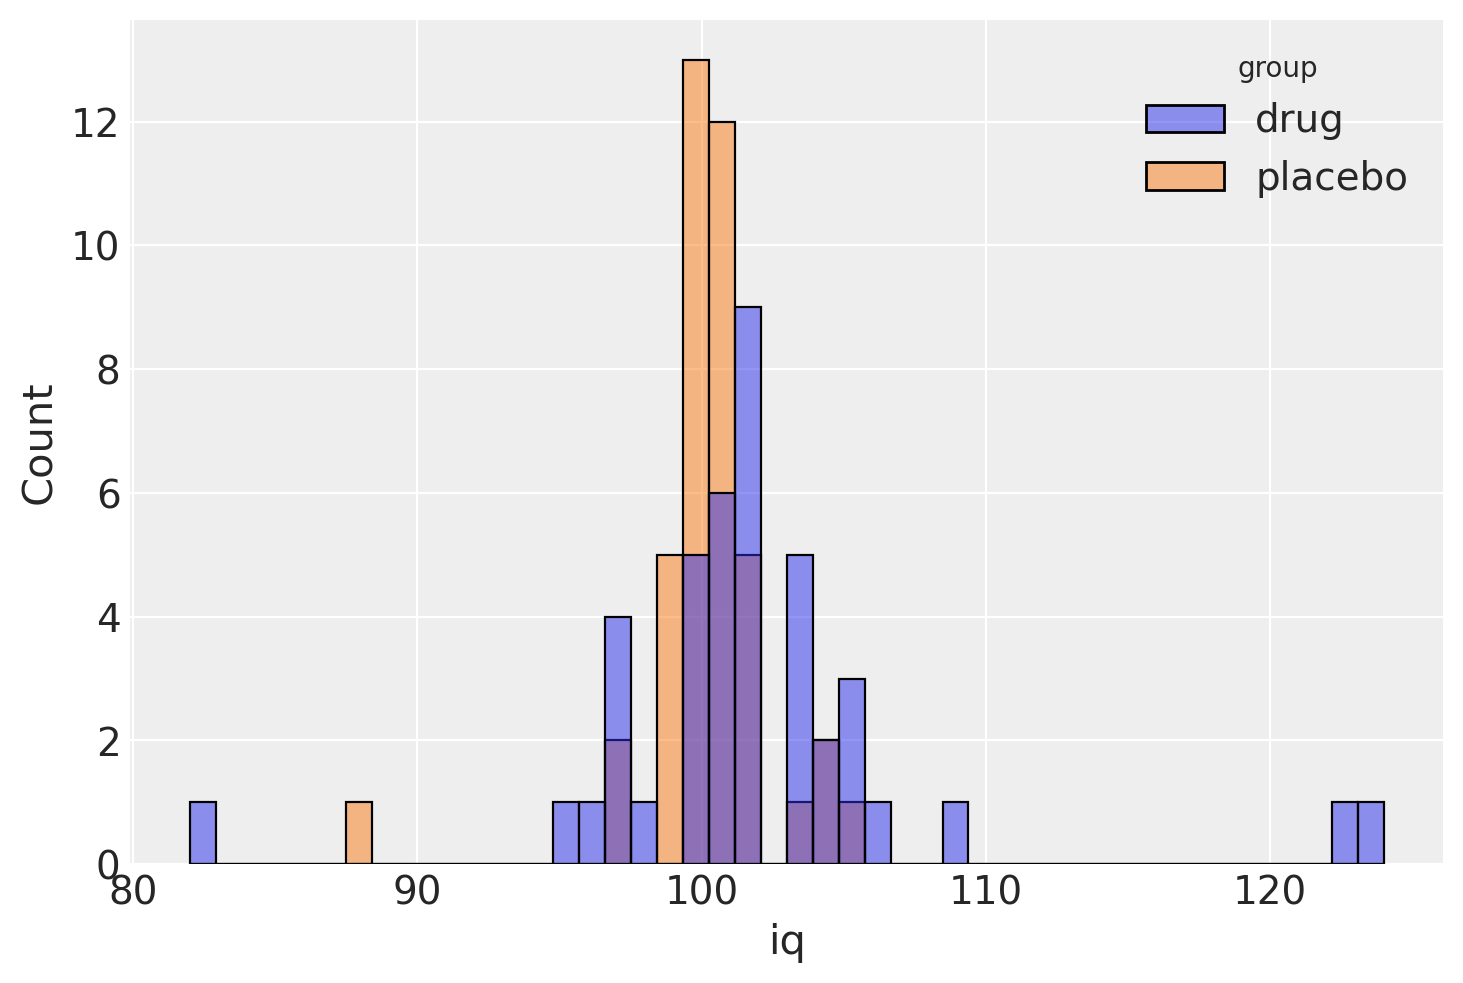

In [22]:
# fmt: off
# iq_drug = np.array([
#     101, 100, 102, 104, 102, 97, 105, 105, 98, 101, 100, 123, 105, 103, 
#     100, 95, 102, 106, 109, 102, 82, 102, 100, 102, 102, 101, 102, 102,
#     103, 103, 97, 97, 103, 101, 97, 104, 96, 103, 124, 101, 101, 100,
#     101, 101, 104, 100, 101
# ])

iq_drug = np.array([
    101, 100, 102, 104, 102, 97, 105, 105, 98, 101, 100, 123, 105, 103, 
    100, 95, 102, 106, 109, 102, 82, 102, 100, 102, 102, 101, 102, 102,
    103, 103, 97, 97, 103, 101, 97, 104, 96, 103, 124, 101, 101, 100
])

iq_placebo = np.array([
    99, 101, 100, 101, 102, 100, 97, 101, 104, 101, 102, 102, 100, 105,
    88, 101, 100, 104, 100, 100, 100, 101, 102, 103, 97, 101, 101, 100,
    101, 99, 101, 100, 100, 101, 100, 99, 101, 100, 102, 99, 100, 99
])
# fmt: on

df1 = pd.DataFrame({"iq": iq_drug, "group": "drug"})
df2 = pd.DataFrame({"iq": iq_placebo, "group": "placebo"})
indv = pd.concat([df1, df2]).reset_index()
#indv["group"] = indv["group"].astype("category")

sns.histplot(data=indv, x="iq", hue="group");

In [47]:
# idata = compare_two_groups(indv["iq"], indv["group"], 1, 10)
idata = compare_one_group(indv["iq"], indv["group"])

-1.619047619047619


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_minus_one, sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [48]:
from scipy import stats

stats.ttest_rel(iq_drug, iq_placebo)

Ttest_relResult(statistic=1.6051696857443507, pvalue=0.11613257982400843)

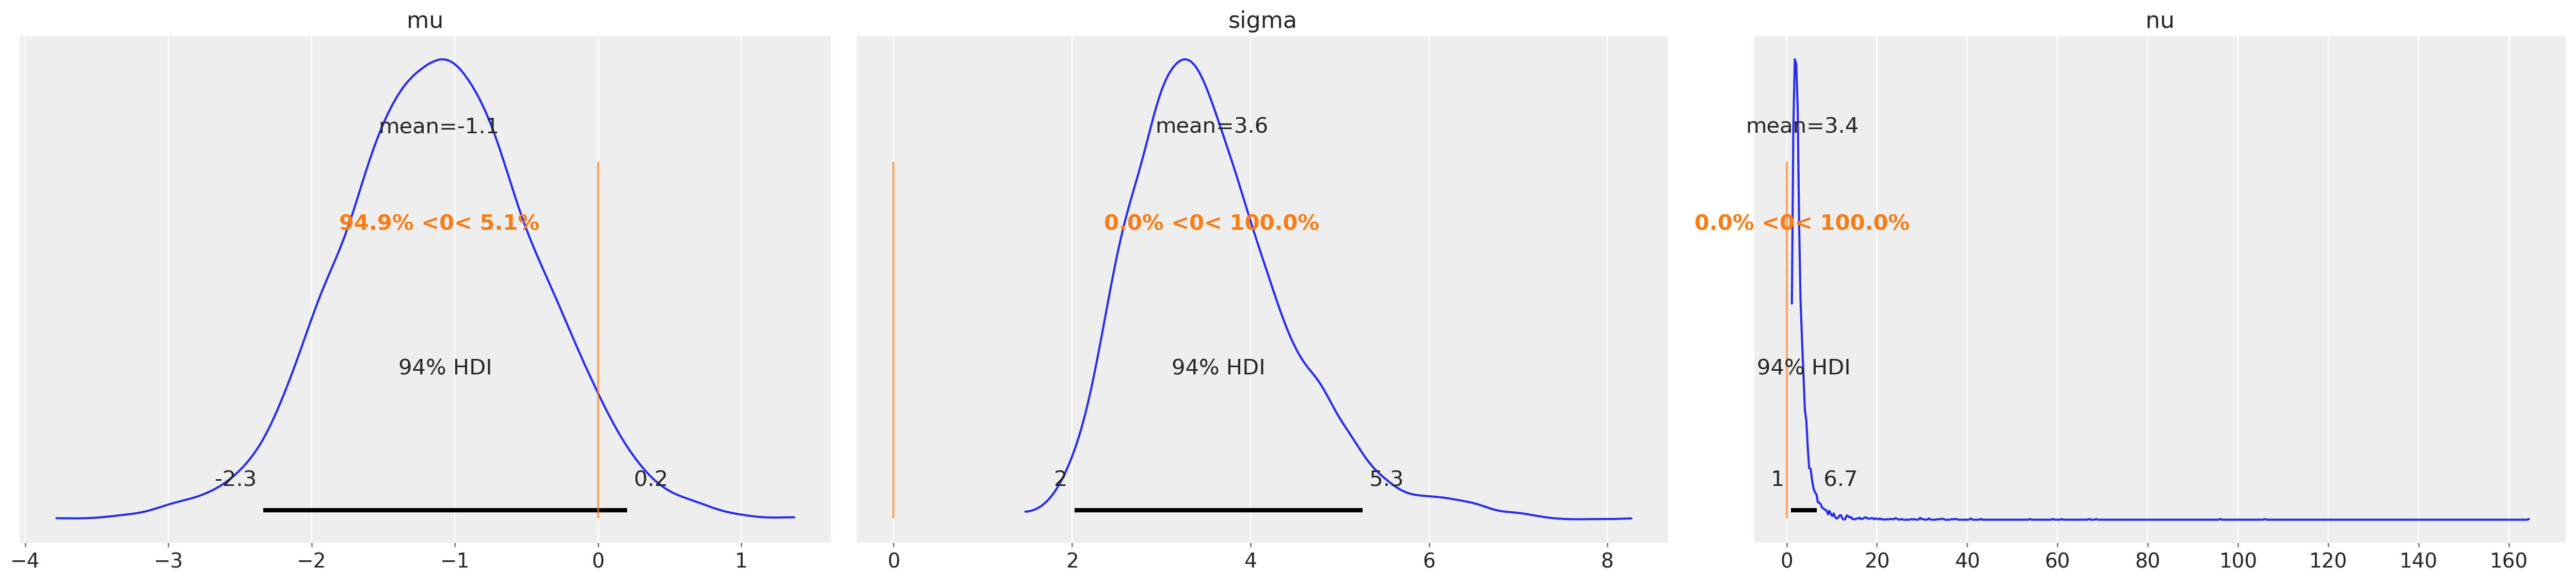

In [49]:
az.plot_posterior(
    idata,
    var_names=["mu", "sigma", "nu"],
    ref_val=0
);

In [ ]:
az.plot_posterior(
    idata,
    var_names=["group1_mean", "group2_mean", "group1_std", "group2_std", "nu_minus_one"],
    color="#87ceeb",
);

In [ ]:
az.plot_posterior(
    idata,
    var_names=["difference of means", "difference of stds", "effect size"],
    ref_val=0,
    color="#87ceeb",
);

In [ ]:
az.plot_forest(idata, var_names=["group1_mean", "group2_mean"]);

In [ ]:
az.plot_forest(idata, var_names=["group1_std", "group2_std", "nu_minus_one"]);

In [ ]:
az.summary(idata, var_names=["difference of means", "difference of stds", "effect size"])   


In [ ]:
idata.posterior

In [ ]:
az.plot_trace(idata);